In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Sentiment analysis/drugsComTrain_raw_sentiment.csv', encoding= 'unicode_escape')

In [ ]:
dataset.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,Sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Positive


In [ ]:
dataset['rating'].value_counts()

10    50989
9     27531
1     21619
8     18890
7      9456
5      8013
2      6931
3      6513
6      6343
4      5012
Name: rating, dtype: int64

In [ ]:
! pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-hseqk12y
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-hseqk12y
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11754 sha256=8f6311c1c2883a0c00ca130bd27ff856535b04ac367e7e84fb8ef4bd37e95aee
  Stored in directory: /tmp/pip-ephem-wheel-cache-0yyois53/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as ps
import re

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [ ]:
dataset['review'] = dataset['review'].apply(lambda x: get_clean(x))

**1. SVM**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
tfidf = TfidfVectorizer(max_features=40000, ngram_range=(1,5),  stop_words='english' , analyzer='word')

In [ ]:
dataset['review']

0         it has no side effect i take it in combination...
1         my son is halfway through his fourth week of i...
2         i used to take another oral contraceptive whic...
3         this is my first time using any form of birth ...
4         suboxone has completely turned my life around ...
                                ...                        
161292    i wrote my first report in midoctober of 2014 ...
161293    i was given this in iv before surgey i immedia...
161294    limited improvement after 4 months developed b...
161295    ive been on thyroid medication 49 years i spen...
161296    ive had chronic constipation all my adult life...
Name: review, Length: 161297, dtype: object

In [ ]:
X = tfidf.fit_transform(dataset['review'])
Y = dataset['Sentiment']

In [ ]:
X

<161297x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 7374818 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape, Y.shape

((161297, 40000), (161297,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [ ]:
X_train.shape

(129037, 40000)

In [ ]:
Y_train.shape

(129037,)

In [ ]:
clf = LinearSVC(C=10, class_weight='balanced')
clf.fit(X_train, Y_train)

LinearSVC(C=10, class_weight='balanced')

In [ ]:
SVM_pred = clf.predict(X_test)

In [ ]:
SVM_acc = accuracy_score(Y_test, SVM_pred)
print(SVM_acc)

0.8005889646621203


In [ ]:
print(classification_report(Y_test, SVM_pred))

              precision    recall  f1-score   support

    Negative       0.77      0.77      0.77      7040
     Neutral       0.58      0.63      0.60      5759
    Positive       0.89      0.86      0.87     19461

    accuracy                           0.80     32260
   macro avg       0.74      0.75      0.75     32260
weighted avg       0.81      0.80      0.80     32260



In [ ]:
x = 'this product is really bad. I do not like it'
x = get_clean(x)
vec = tfidf.transform([x])
clf.predict(vec)

array(['Negative'], dtype=object)

In [ ]:
x = 'this product is really good. I liked it so much'
x = get_clean(x)
vec = tfidf.transform([x])
clf.predict(vec)

array(['Positive'], dtype=object)

Text(0.5, 145.31999999999996, 'Predicted')

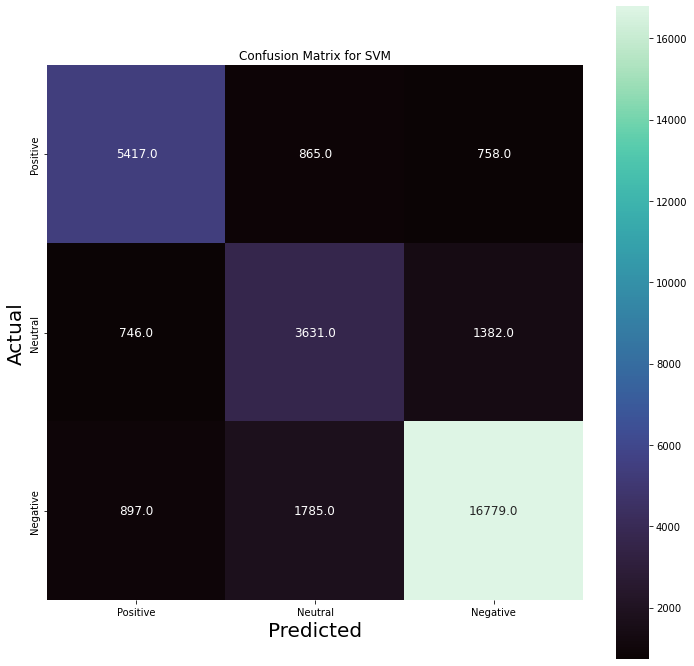

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
Ypred = SVM_pred
label=['Positive', 'Neutral','Negative']
Ytrue = Y_test 
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title("Confusion Matrix for SVM")
ax = sns.heatmap(cm, cmap="mako", fmt=".01f",annot_kws={'size':12}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

**2. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier(max_depth=6, random_state=1)
# Predict test set labels
dt.fit(X_train, Y_train)
DT_pred = dt.predict(X_test)

# Compute test set accuracy
acc = accuracy_score(Y_test, DT_pred)
print("Test set accuracy: {:.2f}".format(acc))

Test set accuracy: 0.62


In [ ]:
print(classification_report(Y_test, DT_pred))

              precision    recall  f1-score   support

    Negative       0.56      0.12      0.20      7040
     Neutral       0.48      0.00      0.00      5759
    Positive       0.62      0.98      0.76     19461

    accuracy                           0.62     32260
   macro avg       0.55      0.37      0.32     32260
weighted avg       0.58      0.62      0.50     32260



Text(0.5, 145.31999999999996, 'Predicted')

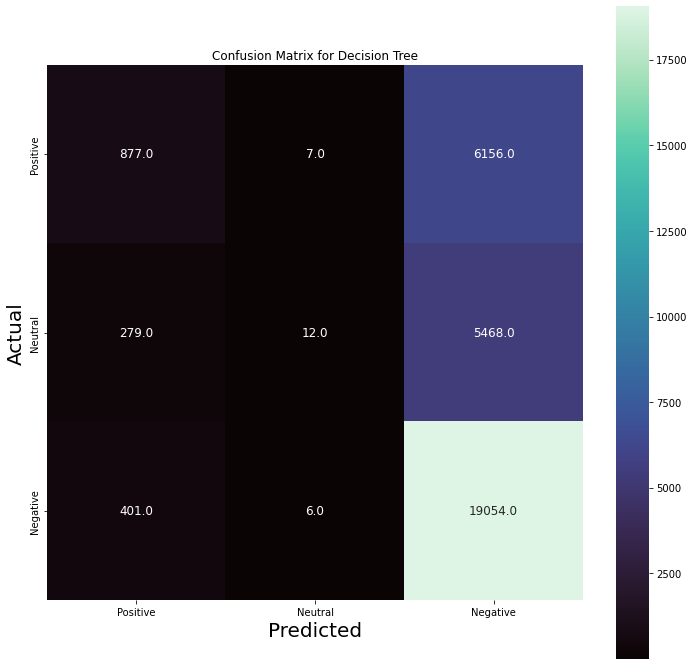

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
Ypred = DT_pred
label=['Positive', 'Neutral','Negative']
Ytrue = Y_test 
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title("Confusion Matrix for Decision Tree")
ax = sns.heatmap(cm, cmap="mako", fmt=".01f",annot_kws={'size':12}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

**3. Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf_NB = MultinomialNB()
clf_NB.fit(X_train, Y_train)

MultinomialNB()

In [ ]:
NB_pred = clf_NB.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, NB_pred))

              precision    recall  f1-score   support

    Negative       0.73      0.53      0.61      7040
     Neutral       0.56      0.15      0.24      5759
    Positive       0.73      0.96      0.83     19461

    accuracy                           0.72     32260
   macro avg       0.67      0.54      0.56     32260
weighted avg       0.70      0.72      0.67     32260



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, NB_pred))
print(classification_report(Y_test, NB_pred))

[[ 3714   298  3028]
 [  896   861  4002]
 [  468   391 18602]]
              precision    recall  f1-score   support

    Negative       0.73      0.53      0.61      7040
     Neutral       0.56      0.15      0.24      5759
    Positive       0.73      0.96      0.83     19461

    accuracy                           0.72     32260
   macro avg       0.67      0.54      0.56     32260
weighted avg       0.70      0.72      0.67     32260



Text(0.5, 145.31999999999996, 'Predicted')

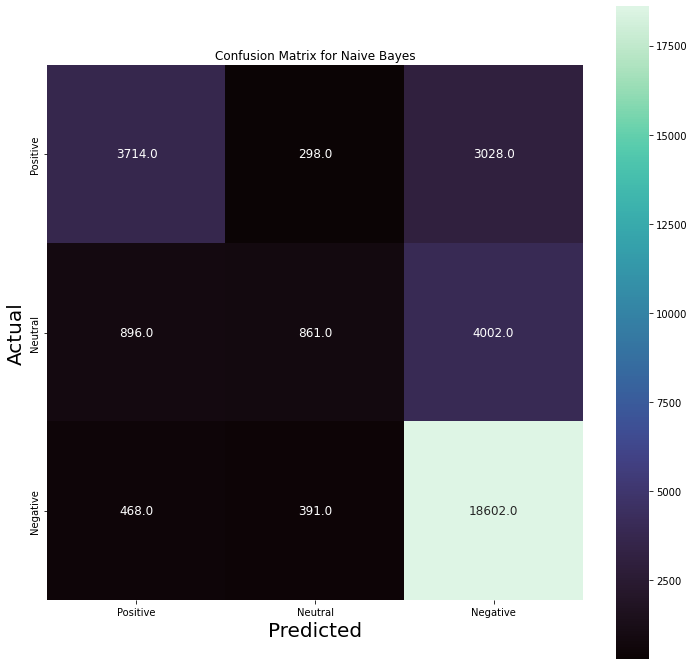

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
Ypred = NB_pred
label=['Positive', 'Neutral','Negative']
Ytrue = Y_test 
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title("Confusion Matrix for Naive Bayes")
ax = sns.heatmap(cm, cmap="mako", fmt=".01f",annot_kws={'size':12}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

**4. K-NN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, Y_train)

KNeighborsClassifier()

In [ ]:
KNN_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, KNN_pred))
print(classification_report(Y_test, KNN_pred))

[[ 1195   114  5731]
 [  560   453  4746]
 [  872   217 18372]]
              precision    recall  f1-score   support

    Negative       0.45      0.17      0.25      7040
     Neutral       0.58      0.08      0.14      5759
    Positive       0.64      0.94      0.76     19461

    accuracy                           0.62     32260
   macro avg       0.56      0.40      0.38     32260
weighted avg       0.59      0.62      0.54     32260



Text(0.5, 145.31999999999996, 'Predicted')

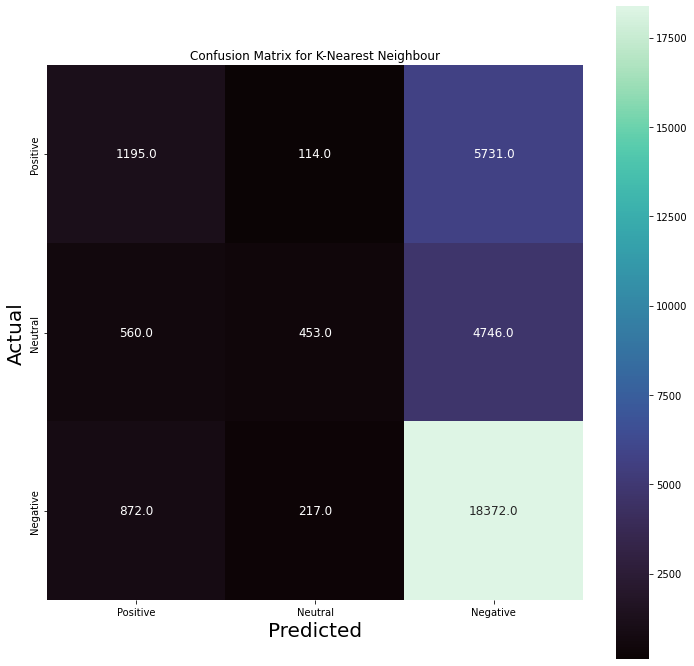

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
Ypred = KNN_pred
label=['Positive', 'Neutral','Negative']
Ytrue = Y_test 
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title("Confusion Matrix for K-Nearest Neighbour")
ax = sns.heatmap(cm, cmap="mako", fmt=".01f",annot_kws={'size':12}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

**Neural Network**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
nnc = MLPClassifier(hidden_layer_sizes=(9),activation="relu",max_iter=1000)
nnc.fit(X_train, Y_train)
nnc_predictions =nnc.predict(X_test)
nnc_acc=accuracy_score(Y_test, nnc_predictions)
print(nnc_acc)

0.8208307501549907


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, nnc_predictions))

              precision    recall  f1-score   support

    Negative       0.78      0.77      0.78      7040
     Neutral       0.63      0.65      0.64      5759
    Positive       0.89      0.89      0.89     19461

    accuracy                           0.82     32260
   macro avg       0.77      0.77      0.77     32260
weighted avg       0.82      0.82      0.82     32260



Text(0.5, 145.31999999999996, 'Predicted')

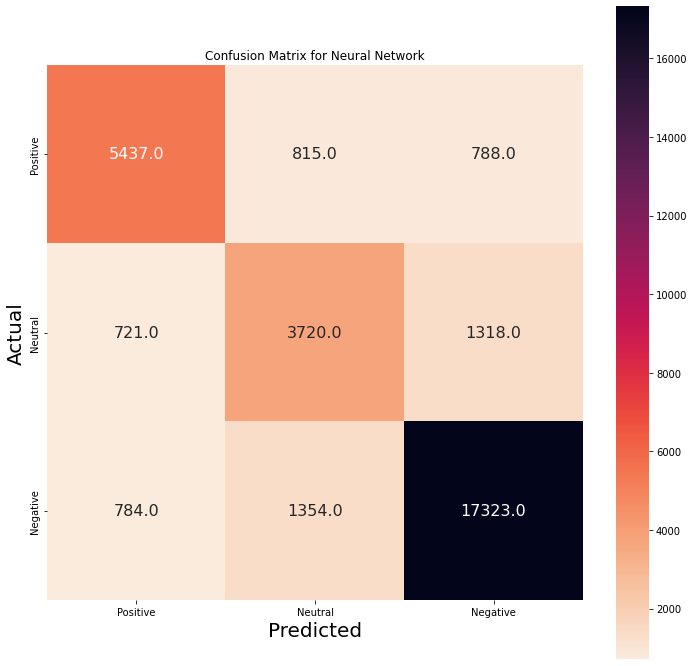

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
Ypred = nnc_predictions
label=['Positive', 'Neutral','Negative']
Ytrue = Y_test
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title("Confusion Matrix for Neural Network")
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)